# Udacity Self-Driving Car Engineer Nanodegree Program
## Vehicle Detection Project

---

Built by Dmitry Zaganich in September 2017

---
This is a system for detecting vehicles in the video. My pipeline was build as follows:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and 
* Train a Linear SVM classifier
* Use sliding window technique to split image into region of intrest
* Run the classifier on these regions and remember detections
* Build a heat-map from these detections in order to combine overlapping detections and remove false positives
* Detect number of cars in image with scipy.ndimage.measurements label() function
* Estimate a bounding box for vehicles detected
* Draw final detection boxes on the image
* Combine detections from previous frames when running pipeline on a video stream

---

## Step 0. Project dependencies & utils

In [1]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time

%matplotlib inline

In [2]:
# shows a table with images and labels
def show_table(images, titles, table_w, table_h):
    fig, axs = plt.subplots(table_h, table_w, figsize=(16, 16))
    fig.subplots_adjust(hspace = .2, wspace=.001)
    axs = axs.ravel()

    for idx in np.arange(len(images)):
        image = images[idx]
        title = titles[idx]
        
        axs[idx].axis('off')
        axs[idx].set_title(title, fontsize=10)
        axs[idx].imshow(image)
        
    plt.show()
    
def show_big_table_gray(images, titles, table_w, table_h):
    fig, axs = plt.subplots(table_h, table_w, figsize=(20, 80))
    fig.subplots_adjust(hspace = .2, wspace=.001)
    axs = axs.ravel()

    for idx in np.arange(len(images)):
        image = images[idx]
        title = titles[idx]
        
        axs[idx].axis('off')
        axs[idx].set_title(title, fontsize=10)
        axs[idx].imshow(image, cmap='gray')
        
    plt.show()

## Step 1. Dataset exploration

In [3]:
# load the dataset

car_images = glob.glob('training_dataset/vehicles/**/*.png')
noncar_images = glob.glob('training_dataset/non-vehicles/**/*.png')

In [4]:
# show number of examples in each class

print("Number of 'cars' images: ", len(car_images))
print("Number of 'non-cars' images: ", len(noncar_images))

Number of 'cars' images:  8792
Number of 'non-cars' images:  8968


In [5]:
# show shapes of images in the dataset

random_idx = np.random.randint(0, len(car_images))
    
car_image = cv2.imread(car_images[random_idx])
car_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2RGB)
    
random_idx = np.random.randint(0, len(noncar_images))
    
noncar_image = cv2.imread(noncar_images[random_idx])
noncar_image = cv2.cvtColor(noncar_image, cv2.COLOR_BGR2RGB)
      
print("'A car' image shape: ", car_image.shape)
print("'Not a car' image shape: ", noncar_image.shape)

'A car' image shape:  (64, 64, 3)
'Not a car' image shape:  (64, 64, 3)


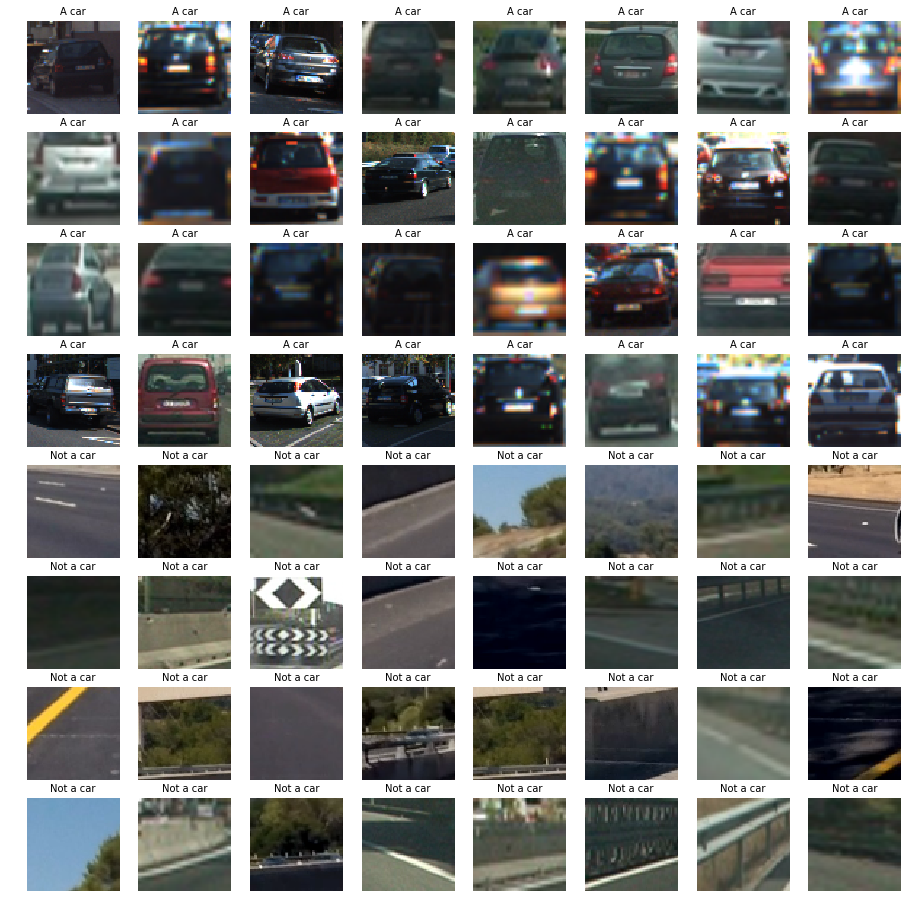

In [6]:
# visualize the dataset

images = []
titles = []

table_w = 8
table_h = 8

table_len = table_w * table_h
        
for idx in np.arange(table_len/2):
    random_idx = np.random.randint(0, len(car_images))
    
    image = cv2.imread(car_images[random_idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    images.append(image)
    titles.append("A car")
    
for idx in np.arange(table_len/2, table_len):
    random_idx = np.random.randint(0, len(noncar_images))
    
    image = cv2.imread(noncar_images[random_idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    images.append(image)
    titles.append("Not a car")
    
show_table(images, titles, table_w, table_h)

Both classes have roughly same number of entities, so data augmentation is not required. The images are quite small (64x64 pixels in each) and different from each other, so we need some advanced techniques to extract distinct features from them.

## Step 2. Histogram of Oriented Gradients (HOG)

'Histogram of Oriented Gradients' was suggested in the lectures for this project, so I implemented functions (based on the lesson materials) to extract hog features from single and multiple images. 

The functions which were used in this part of my project:
* 'get_hog_features' gets hog features from an image
* 'extract_features_from_image' converts image to a specified color space and calls get_hog_features on it
* 'extract_features' gets features from an array of images. 

In [7]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        
        return features, hog_image
    
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        
        return features

In [9]:
def extract_features_from_image(image, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
    return hog_features

def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    features = []
    
    for file in imgs:
        
        image = mpimg.imread(file)
        
        hog_features = extract_features_from_image(image, cspace, orient, 
                        pix_per_cell, cell_per_block, hog_channel)
            
        features.append(hog_features)
        
    return features

Let's check how these histograms look like when we use different color spaces, orientations and apply them to different channels of an image. 
I did some research in the web and looked on the different approaches of the other students which I've found here: https://github.com/frankkanis/CarND-Student-Blogs. 
Although most of them used unique combinations of the parametres, I still roughly determined the ranges of the parametres which I can later explore myself.

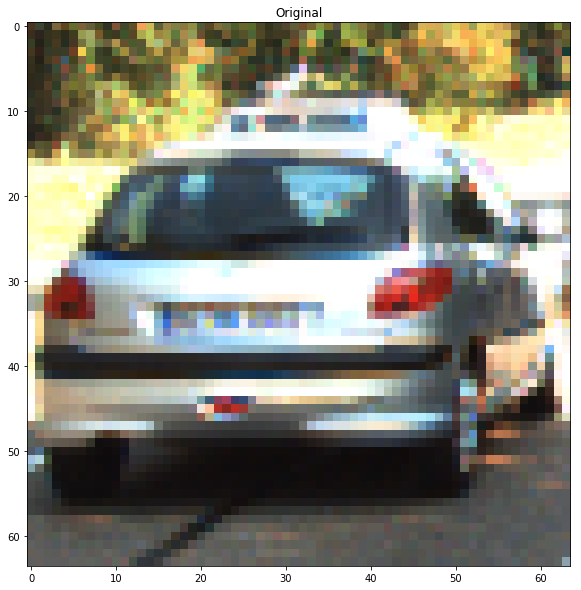

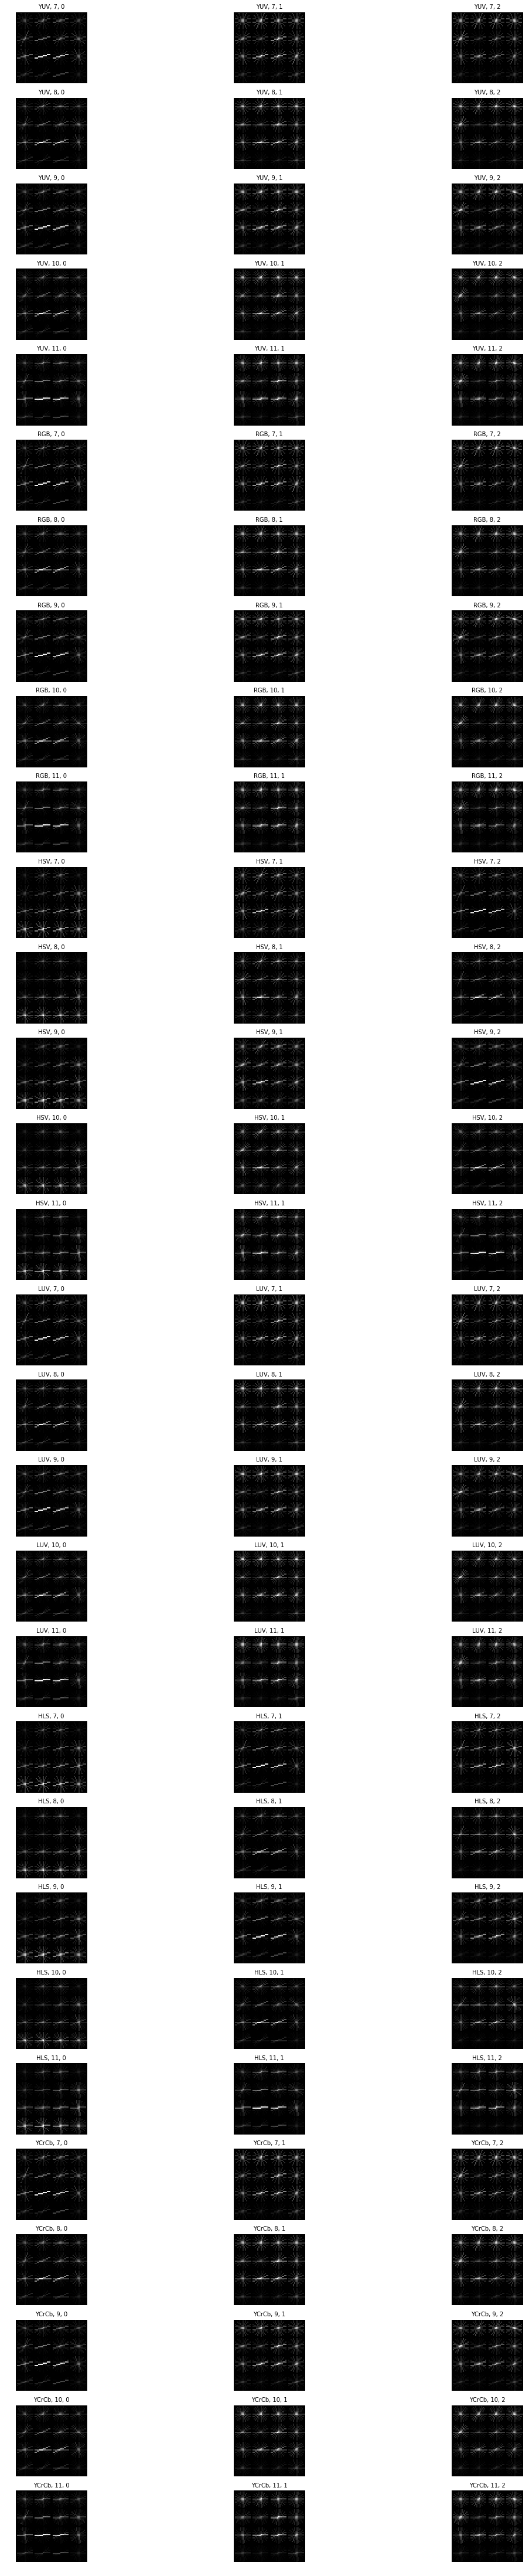

In [10]:
test_colorspaces = ['YUV', 'RGB', 'HSV', 'LUV', 'HLS', 'YCrCb']
test_orientations = [7, 8, 9, 10, 11]
test_hog_channels = [0, 1, 2]

test_pix_per_cell = 16
test_cell_per_block = 2

random_idx = np.random.randint(0, len(car_images))
image = mpimg.imread(car_images[random_idx])

images = []
titles = []

table_h = len(test_colorspaces)*len(test_orientations)
table_w = len(test_hog_channels)

for colorspace in test_colorspaces:
    
    if colorspace != 'RGB':
        if colorspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif colorspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif colorspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif colorspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif colorspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(image) 
    
    for orientation in test_orientations:
        for hog_channel in test_hog_channels:
            _, car_image_hog = get_hog_features(feature_image[:,:,hog_channel], orientation, 
                              test_pix_per_cell, test_cell_per_block, 
                              vis=True, feature_vec=True)
            title = ""+str(colorspace)+", "+str(orientation)+", "+str(hog_channel)
            
            images.append(car_image_hog)
            titles.append(title)
            
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.title("Original")

show_big_table_gray(images, titles, table_w, table_h)

The outputs of different sets of parametres look a lot similar, but we can observe that some of them, like the ones generated with HSV and YUV color spaces look like the ones which we can use.
I actually tried to guess the parametres when I started working on this project, but later I decided that I don't really need to guess them.
I can try them all and pick the best combination.

So I decided to do parameter tuning like that:

* Train SVC classifier on all of the combinations of the parametres
* Pick 10 combinations with the best score on the test set
* Manually provide these parametres to the pipeline and see which one works the best on the project video

The functions which were used in this part of my project:
* 'train_classifier' extracts features from the dataset, splits it on training and test sets, trains classifier using provided parametres and returns a trained classifier and a score on the test set

Note, that I did not have to use normalization on my features, because I only use "hog" features in my pipeline.

So, let's start with some classification using Support Vector Machines!

In [11]:
def train_classifier(colorspace, orientation, pix_per_cell, cell_per_block, hog_channel):

    print("Test model: \n colorspace: %s \n hog_channel: %s \n orientation: %d \n pix_per_cell: %d \n cell_per_block: %d" 
          % (str(colorspace), hog_channel, orientation, pix_per_cell, cell_per_block)) 
    
    car_features = extract_features(car_images, cspace=colorspace, orient=orientation, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    notcar_features = extract_features(noncar_images, cspace=colorspace, orient=orientation, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)  

    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    
    rand_state = np.random.randint(0, 100)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
    
    # Use a linear SVC 
    svc = LinearSVC()

    # Check the training time for the SVC
    start_time = time.time()

    svc.fit(X_train, y_train)

    end_time = time.time()

    print("Model trained in ", round(end_time-start_time, 2), " seconds.")

    # Check the score of the SVC
    score = round(svc.score(X_test, y_test), 4)
    
    print("Test accuracy: ", score)
    
    return svc, score

In [12]:
test_colorspaces = ['YUV', 'RGB', 'HSV', 'LUV', 'HLS', 'YCrCb']
test_orientations = [7, 8, 9, 10, 11]
test_hog_channels = ['ALL', 0, 1, 2]

test_pix_per_cell = 16
test_cell_per_block = 2

parametres = []
scores = []

for colorspace in test_colorspaces:
    for orientation in test_orientations:
        for hog_channel in test_hog_channels:
            print("\n ---- \n")
            svc, score = train_classifier(colorspace, orientation, test_pix_per_cell, test_cell_per_block, hog_channel)
            
            parametres.append([colorspace, orientation, hog_channel])
            scores.append(score)


 ---- 

Test model: 
 colorspace: YUV 
 hog_channel: ALL 
 orientation: 7 
 pix_per_cell: 16 
 cell_per_block: 2
Model trained in  0.86  seconds.
Test accuracy:  0.9814

 ---- 

Test model: 
 colorspace: YUV 
 hog_channel: 0 
 orientation: 7 
 pix_per_cell: 16 
 cell_per_block: 2
Model trained in  0.43  seconds.
Test accuracy:  0.9459

 ---- 

Test model: 
 colorspace: YUV 
 hog_channel: 1 
 orientation: 7 
 pix_per_cell: 16 
 cell_per_block: 2
Model trained in  0.46  seconds.
Test accuracy:  0.933

 ---- 

Test model: 
 colorspace: YUV 
 hog_channel: 2 
 orientation: 7 
 pix_per_cell: 16 
 cell_per_block: 2
Model trained in  0.5  seconds.
Test accuracy:  0.9203

 ---- 

Test model: 
 colorspace: YUV 
 hog_channel: ALL 
 orientation: 8 
 pix_per_cell: 16 
 cell_per_block: 2
Model trained in  0.86  seconds.
Test accuracy:  0.9856

 ---- 

Test model: 
 colorspace: YUV 
 hog_channel: 0 
 orientation: 8 
 pix_per_cell: 16 
 cell_per_block: 2
Model trained in  0.55  seconds.
Test accuracy

 cell_per_block: 2
Model trained in  0.74  seconds.
Test accuracy:  0.9093

 ---- 

Test model: 
 colorspace: HLS 
 hog_channel: 1 
 orientation: 11 
 pix_per_cell: 16 
 cell_per_block: 2
Model trained in  0.71  seconds.
Test accuracy:  0.9471

 ---- 

Test model: 
 colorspace: HLS 
 hog_channel: 2 
 orientation: 11 
 pix_per_cell: 16 
 cell_per_block: 2
Model trained in  0.74  seconds.
Test accuracy:  0.8778

 ---- 

Test model: 
 colorspace: YCrCb 
 hog_channel: ALL 
 orientation: 7 
 pix_per_cell: 16 
 cell_per_block: 2
Model trained in  0.95  seconds.
Test accuracy:  0.9769

 ---- 

Test model: 
 colorspace: YCrCb 
 hog_channel: 0 
 orientation: 7 
 pix_per_cell: 16 
 cell_per_block: 2
Model trained in  0.44  seconds.
Test accuracy:  0.9431

 ---- 

Test model: 
 colorspace: YCrCb 
 hog_channel: 1 
 orientation: 7 
 pix_per_cell: 16 
 cell_per_block: 2
Model trained in  0.5  seconds.
Test accuracy:  0.9316

 ---- 

Test model: 
 colorspace: YCrCb 
 hog_channel: 2 
 orientation: 7 


In [13]:
sorted_scores = sorted(scores)

top_num = 10

print("print models with top ", top_num, " accuracies")

for idx in range(top_num):
    top_score = sorted_scores[-(idx+1)]
    
    idx_in_scores = scores.index(top_score)
    model_params = parametres[idx_in_scores]
    
    print("\n Model parametres: \n colorspace: %s \n hog_channel: %s \n orientation: %d \n pix_per_cell: %d \n cell_per_block: %d \n" 
          % (str(model_params[0]), model_params[2], model_params[1], test_pix_per_cell, test_cell_per_block))
    print("Model accuracy: ", top_score)

print models with top  10  accuracies

 Model parametres: 
 colorspace: YUV 
 hog_channel: ALL 
 orientation: 8 
 pix_per_cell: 16 
 cell_per_block: 2 

Model accuracy:  0.9856

 Model parametres: 
 colorspace: YUV 
 hog_channel: ALL 
 orientation: 9 
 pix_per_cell: 16 
 cell_per_block: 2 

Model accuracy:  0.9851

 Model parametres: 
 colorspace: YCrCb 
 hog_channel: ALL 
 orientation: 8 
 pix_per_cell: 16 
 cell_per_block: 2 

Model accuracy:  0.984

 Model parametres: 
 colorspace: YUV 
 hog_channel: ALL 
 orientation: 10 
 pix_per_cell: 16 
 cell_per_block: 2 

Model accuracy:  0.9828

 Model parametres: 
 colorspace: YUV 
 hog_channel: ALL 
 orientation: 10 
 pix_per_cell: 16 
 cell_per_block: 2 

Model accuracy:  0.9828

 Model parametres: 
 colorspace: YCrCb 
 hog_channel: ALL 
 orientation: 11 
 pix_per_cell: 16 
 cell_per_block: 2 

Model accuracy:  0.9825

 Model parametres: 
 colorspace: HLS 
 hog_channel: ALL 
 orientation: 10 
 pix_per_cell: 16 
 cell_per_block: 2 

Model 

It seems like using high values of "orientation" and all of the image channels is the way to go. However, it's not just about scores on the test set, right? 
I did not included results of my exploration of the top combinations, but in the end I determined that "YUV" color space provides the best result on the project test video, because all other top combinations gave me way more false positives on the video.

The final set of parametres for extracting HOG features is listed below:
* colorspace = 'YUV'
* orientation = 11
* all of the channels

Let's look how this set does on the random images of each class from the dataset.

In [14]:
colorspace = 'YUV'
orientation = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL'

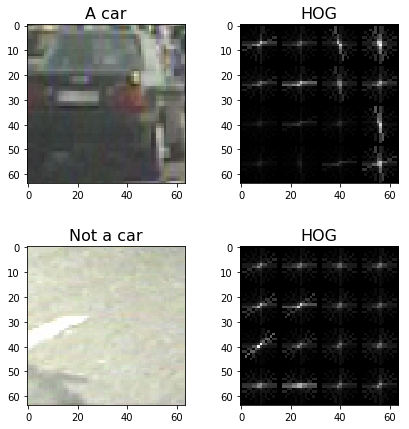

In [15]:
random_idx = np.random.randint(0, len(car_images))
car_image = mpimg.imread(car_images[random_idx])

random_idx = np.random.randint(0, len(noncar_images))
noncar_image = mpimg.imread(noncar_images[random_idx])

_, car_image_hog = get_hog_features(car_image[:,:,2], orientation, 
                              pix_per_cell, cell_per_block, 
                              vis=True, feature_vec=True)


_, noncar_image_hog = get_hog_features(noncar_image[:,:,2], orientation, 
                                 pix_per_cell, cell_per_block, 
                                 vis=True, feature_vec=True)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)

ax1.imshow(car_image)
ax1.set_title('A car', fontsize=16)

ax2.imshow(car_image_hog, cmap='gray')
ax2.set_title('HOG', fontsize=16)

ax3.imshow(noncar_image)
ax3.set_title('Not a car', fontsize=16)

ax4.imshow(noncar_image_hog, cmap='gray')
ax4.set_title('HOG', fontsize=16)

So, now I am finally able train my classifier and start actually searching for cars in my images!

In [16]:
print("Final model: \n colorspace: %s \n hog_channel: %s \n orientation: %d \n pix_per_cell: %d \n cell_per_block: %d" 
          % (str(colorspace), hog_channel, orientation, pix_per_cell, cell_per_block)) 
    
car_features = extract_features(car_images, cspace=colorspace, orient=orientation, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
notcar_features = extract_features(noncar_images, cspace=colorspace, orient=orientation, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)

X = np.vstack((car_features, notcar_features)).astype(np.float64)  

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=rand_state)
    
# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
start_time = time.time()

svc.fit(X_train, y_train)

end_time = time.time()

print("Model trained in ", round(end_time-start_time, 2), " seconds.")

# Check the score of the SVC
score = round(svc.score(X_test, y_test), 4)
    
print("Test accuracy: ", score)

Final model: 
 colorspace: YUV 
 hog_channel: ALL 
 orientation: 11 
 pix_per_cell: 16 
 cell_per_block: 2
Model trained in  1.43  seconds.
Test accuracy:  0.9868


## Step 3. Sliding Window Search

My next step was to implement sliding window search in my pipeline. This step requires splitting image in so-called "windows" and then running previously trained classifier on them to detect ones with a car (or a portion of the car) in them.
I decided to cut my region of interest out of processed image (inspired by lanes detection project) so the pipeline will not waste valuable computational resources on the parts of image which are not that meaningful (like the upper half with trees and sky) and combine different window sizes to detect cars of different sizes in the frame.

The functions which were used in this part of my project:
* 'find_cars' combines color space conversion, getting a region of interest out of original image, hog feature extraction for an entire region of interest, sliding through the region and using the classifier to make predictions whether a window contains a car or not;
* 'draw_boxes' draws set of boxes with a specified or a random color on the original image
* 'draw_sliding_search' draws all of the search windows on the image and highlight the ones which were predicted as the ones with a car in them

In [ ]:
# determined by the size of images in the dataset
sliding_window = 64

In [18]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(image, 
              y_start, y_stop, 
              scale, 
              color_space, 
              hog_channel, 
              classifier, 
              orientation, 
              pix_per_cell, cell_per_block, 
              show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    # make image values to [0,1]
    image = image.astype(np.float32)/255
    
    # region of interest
    roi_image = image[y_start:y_stop,:,:]

    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            roi_image = cv2.cvtColor(roi_image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            roi_image = cv2.cvtColor(roi_image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            roi_image = cv2.cvtColor(roi_image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            roi_image = cv2.cvtColor(roi_image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            roi_image = cv2.cvtColor(roi_image, cv2.COLOR_RGB2YCrCb)
    else: roi_image = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = roi_image.shape
        roi_image = cv2.resize(roi_image, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        roi_image_channel_1 = roi_image[:, :, 0]
        roi_image_channel_2 = roi_image[:, :, 1]
        roi_image_channel_3 = roi_image[:, :, 2]
    else: 
        roi_image_channel_1 = roi_image[:, :, hog_channel]

    # Define blocks and steps as above
    x_blocks = (roi_image_channel_1.shape[1] // pix_per_cell)+1  #-1
    y_blocks = (roi_image_channel_1.shape[0] // pix_per_cell)+1  #-1
    
    nfeat_per_block = orientation*cell_per_block**2
    
    blocks_per_window = (sliding_window // pix_per_cell)-1 
    
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    
    x_steps = (x_blocks - blocks_per_window) // cells_per_step
    y_steps = (y_blocks - blocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog_channel_1 = get_hog_features(roi_image_channel_1, orientation, pix_per_cell, cell_per_block, feature_vec=False)
    
    if hog_channel == 'ALL':
        hog_channel_2 = get_hog_features(roi_image_channel_2, orientation, pix_per_cell, cell_per_block, feature_vec=False)
        hog_channel_3 = get_hog_features(roi_image_channel_3, orientation, pix_per_cell, cell_per_block, feature_vec=False)
    
    for x_step in range(x_steps):
        for y_step in range(y_steps):
            
            x_pos = x_step*cells_per_step
            y_pos = y_step*cells_per_step
            
            # Extract HOG for this patch
            if hog_channel == 'ALL':
                window_hog_1 = hog_channel_1[y_pos:y_pos+blocks_per_window, x_pos:x_pos+blocks_per_window].ravel()
                window_hog_2 = hog_channel_2[y_pos:y_pos+blocks_per_window, x_pos:x_pos+blocks_per_window].ravel() 
                window_hog_3 = hog_channel_3[y_pos:y_pos+blocks_per_window, x_pos:x_pos+blocks_per_window].ravel() 
                hog_features = np.hstack((window_hog_1, window_hog_2, window_hog_3))
            else:
                hog_features = hog_channel_1[y_pos:y_pos+blocks_per_window, x_pos:x_pos+blocks_per_window].ravel()

            x_left = x_pos*pix_per_cell
            y_top = y_pos*pix_per_cell
            
            prediction = classifier.predict(hog_features)
            
            if prediction == 1 or show_all_rectangles:
                x_box_left = np.int(x_left*scale)
                y_top_draw = np.int(y_top*scale)
                
                win_draw = np.int(sliding_window*scale)
                
                rectangles.append((
                    (x_box_left, y_top_draw+y_start), 
                    (x_box_left+win_draw, y_top_draw+win_draw+y_start)
                ))
                
    return rectangles

In [19]:
def draw_boxes(image, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(image)
    random_color = False
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

In [20]:
def draw_sliding_search(image, y_start, scale, window_steps):
    
    y_stop = y_start + int(sliding_window*scale*window_steps)
    
    roi_image = image[y_start:y_stop,:,:]

    all_rectangles = find_cars(image, 
                       y_start, y_stop, 
                       scale, 
                       colorspace, 
                       hog_channel, 
                       svc, 
                       orientation, 
                       pix_per_cell, cell_per_block, show_all_rectangles=True)

    detected_rectangles = find_cars(image, 
                       y_start, y_stop, 
                       scale, 
                       colorspace, 
                       hog_channel, 
                       svc, 
                       orientation, 
                       pix_per_cell, cell_per_block)

    all_windows_image = draw_boxes(image, all_rectangles)

    detected_image = draw_boxes(all_windows_image, detected_rectangles, color=(255, 0, 0))

    plt.figure(figsize=(10,10))
    plt.imshow(roi_image)
    plt.title("Region of interest")

    plt.figure(figsize=(10,10))
    plt.imshow(detected_image)
    plt.title("Detected windows")

In [21]:
image_test = mpimg.imread('./test_images/test1.jpg')

My sliding search is pretty easy to use: it needs only top "y" position, scale of the search window and how many lines (steps) will be checked in the image with these parametres. Original size of a searching window was determined by the size of an image in the dataset, which is 64x64 pixels.

Let's see how it works out on a test image.

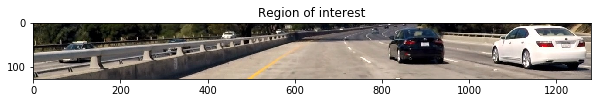

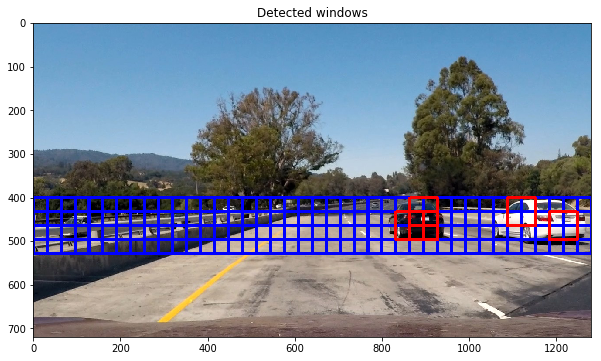

In [22]:
scale = 1.0
y_start = 400
window_steps = 2
draw_sliding_search(image_test, y_start, scale, window_steps)

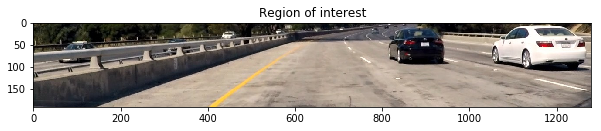

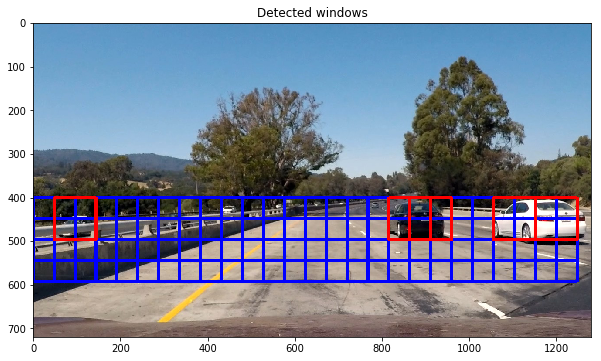

In [23]:
scale = 1.5
y_start = 400
window_steps = 2
draw_sliding_search(image_test, y_start, scale, window_steps)

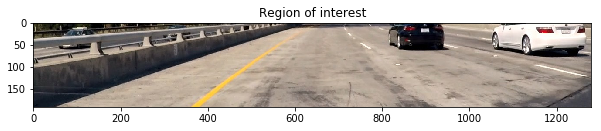

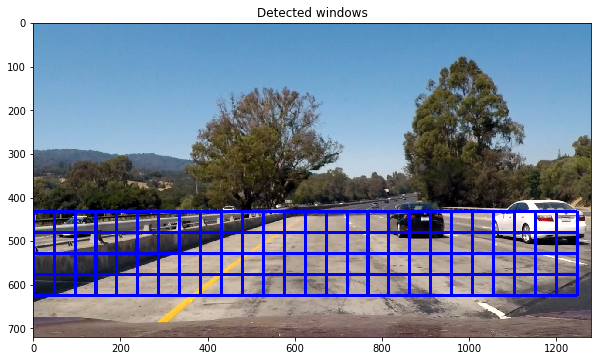

In [24]:
scale = 1.5
y_start = 432
window_steps = 2
draw_sliding_search(image_test, y_start, scale, window_steps)

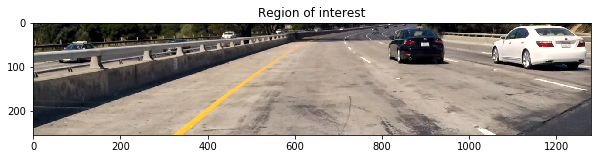

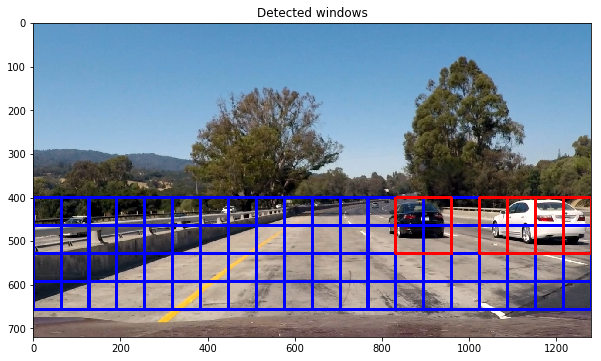

In [25]:
scale = 2.0
y_start = 400
window_steps = 2
draw_sliding_search(image_test, y_start, scale, window_steps)

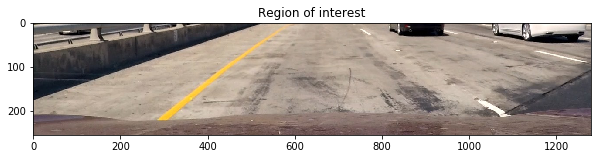

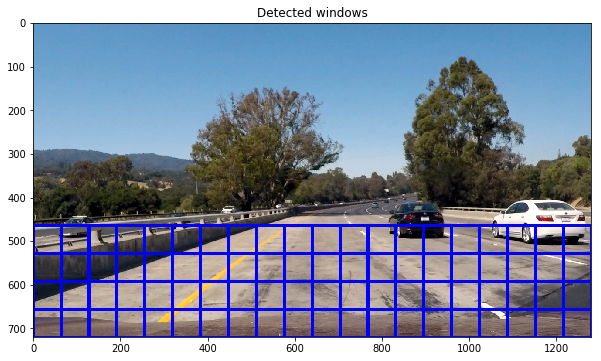

In [26]:
scale = 2.0
y_start = 464
window_steps = 2
draw_sliding_search(image_test, y_start, scale, window_steps)

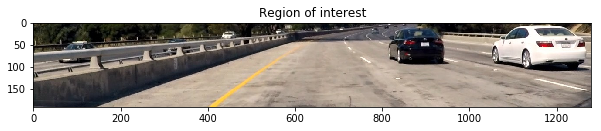

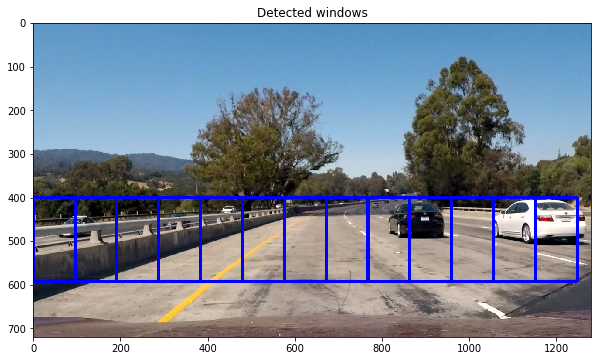

In [27]:
scale = 3.0
y_start = 400
window_steps = 1
draw_sliding_search(image_test, y_start, scale, window_steps)

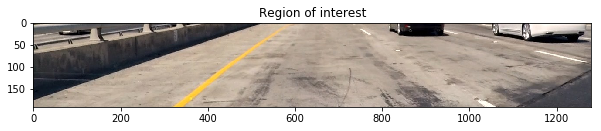

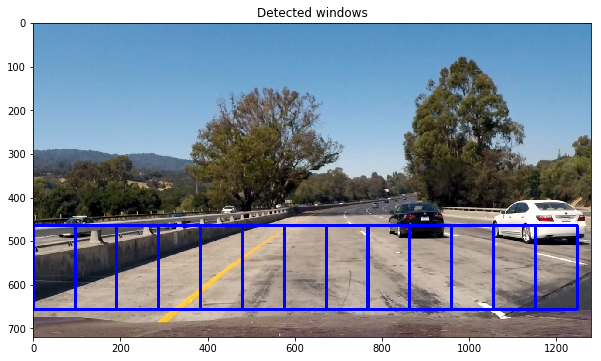

In [28]:
scale = 3.0
y_start = 464
window_steps = 1
draw_sliding_search(image_test, y_start, scale, window_steps)

It actually works pretty well. It even captured a car on the far left which is partially covered by a wall on the center of the road. 
So, now we just need to combine them and see what we've got.

In [29]:
def search_in_region(image, y_start, scale, window_steps):
    
    y_stop = y_start + int(sliding_window*scale*window_steps)
    
    roi_image = image[y_start:y_stop,:,:]

    return find_cars(image, 
                       y_start, y_stop, 
                       scale, 
                       colorspace, 
                       hog_channel, 
                       svc, 
                       orientation, 
                       pix_per_cell, cell_per_block)

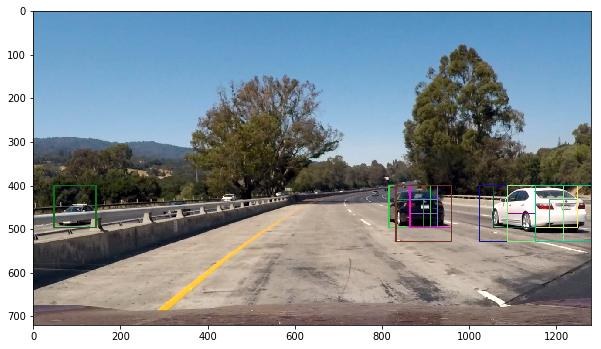

In [30]:
image_test = mpimg.imread('./test_images/test1.jpg')

rectangles = []

scale = 1.0
y_start = 400
window_steps = 2
rectangles.append(search_in_region(image_test, y_start, scale, window_steps))

scale = 1.5
y_start = 400
window_steps = 2
rectangles.append(search_in_region(image_test, y_start, scale, window_steps))

scale = 1.5
y_start = 432
window_steps = 2
rectangles.append(search_in_region(image_test, y_start, scale, window_steps))

scale = 2.0
y_start = 400
window_steps = 2
rectangles.append(search_in_region(image_test, y_start, scale, window_steps))

scale = 2.0
y_start = 464
window_steps = 2
rectangles.append(search_in_region(image_test, y_start, scale, window_steps))

scale = 3.0
y_start = 400
window_steps = 1
rectangles.append(search_in_region(image_test, y_start, scale, window_steps))

scale = 3.0
y_start = 464
window_steps = 1
rectangles.append(search_in_region(image_test, y_start, scale, window_steps))

# apparently this is the best way to flatten a list of lists
rectangles = [item for sublist in rectangles for item in sublist] 

image_test_detected = draw_boxes(image_test, rectangles, color='random', thick=2)

plt.figure(figsize=(10, 10))
plt.imshow(image_test_detected)

The pipeline was able to successfully identify 3 out of 4 cars in the test image. The car which was not identified is a white car near the tree and it is not clearly visible even for a human. 

The two neares cars were identified by a whole set of search windows and a car on the left by just one window.

So, the next step is to combine detections into one and that's were hearmaps are coming to play.

## Step 4. Identifying final detection boxes

In order to identify final detections I used heatmaps to eliminate false positives. The portion of image contains a false positive detection if there are smaller number of overlapping detected rectangles in it than it's required by detection threshold.
After eliminating all of the false positives we draw final detection area on the original image.

The functions which were used in this part of my project:
* 'add_heat' adds +1 to every pixel in the image which is located in the provided boxes
* 'apply_threshold' keeps only the pixels which had "heat" which exceeds a detection threshold. 
* 'draw_labeled_bboxes' draws final detection area on the original image using detections which were filtered by scipy.ndimage.measurements.label() function and heat threshold.

In [31]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

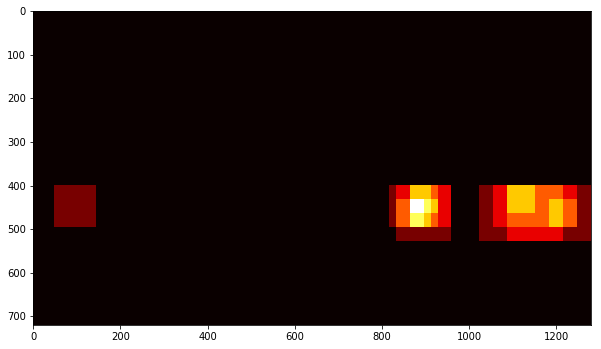

In [32]:
heatmap_test = np.zeros_like(image_test[:,:,0])
heatmap_test = add_heat(heatmap_test, rectangles)

plt.figure(figsize=(10,10))
plt.imshow(heatmap_test, cmap='hot')

### Apply a Threshold to the Heatmap

In [33]:
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

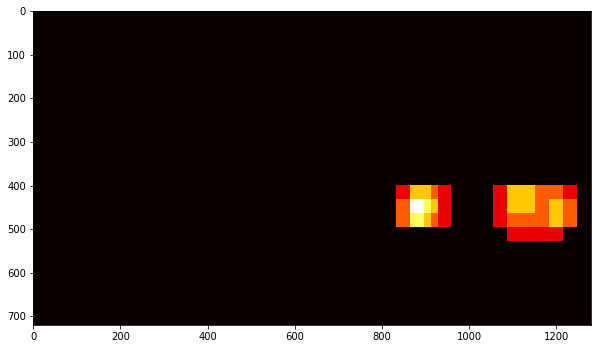

In [34]:
heatmap_thesholded = apply_threshold(heatmap_test, 1)

plt.figure(figsize=(10,10))
plt.imshow(heatmap_thesholded, cmap='hot')

### Apply SciPy Labels to Heatmap

2 cars found


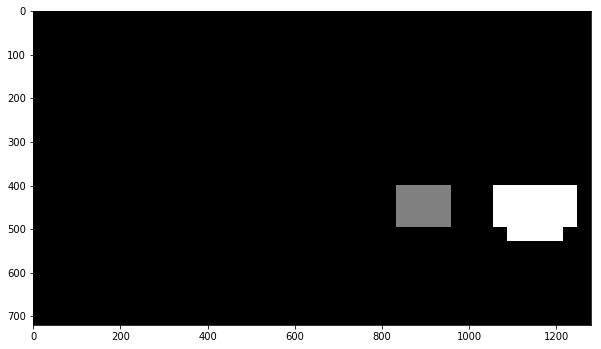

In [35]:
labels = label(heatmap_test)

plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')

print(labels[1], 'cars found')

In [36]:
def draw_labeled_bboxes(image, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(image, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return image, rects

And here the final result of all of the steps above, applied to the test image. It detected two neares cars and roughly estimated their size. 
Unfortunately, the third car detection was eliminated as a false positive because it was detected by only a single window.

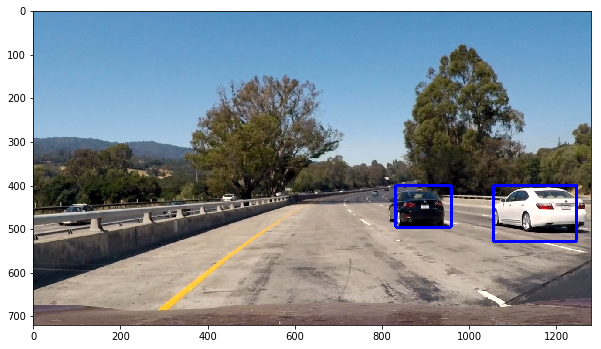

In [37]:
detected_overlay_image, rect = draw_labeled_bboxes(np.copy(image_test), labels)

plt.figure(figsize=(10,10))
plt.imshow(detected_overlay_image)

## Step 5. Testing the pipeline

The combined pipeline is written in the function 'proccess_image' below, which takes an image and returns it with detected regions.

In [38]:
def process_image(image):
    rectangles = []

    scale = 1.0
    y_start = 400
    window_steps = 2
    rectangles.append(search_in_region(image, y_start, scale, window_steps))

    scale = 1.5
    y_start = 400
    window_steps = 2
    rectangles.append(search_in_region(image, y_start, scale, window_steps))

    scale = 1.5
    y_start = 432
    window_steps = 2
    rectangles.append(search_in_region(image, y_start, scale, window_steps))

    scale = 2.0
    y_start = 400
    window_steps = 2
    rectangles.append(search_in_region(image, y_start, scale, window_steps))

    scale = 2.0
    y_start = 464
    window_steps = 2
    rectangles.append(search_in_region(image, y_start, scale, window_steps))

    scale = 3.0
    y_start = 400
    window_steps = 1
    rectangles.append(search_in_region(image, y_start, scale, window_steps))

    scale = 3.0
    y_start = 464
    window_steps = 1
    rectangles.append(search_in_region(image, y_start, scale, window_steps))

    rectangles = [item for sublist in rectangles for item in sublist] 
    
    heatmap_image = np.zeros_like(image[:,:,0])
    heatmap_image = add_heat(heatmap_image, rectangles)
    heatmap_image = apply_threshold(heatmap_image, 1)
    
    labels = label(heatmap_image)
    
    detected_overlay_image, rects = draw_labeled_bboxes(np.copy(image), labels)
    
    return detected_overlay_image

Let's run the pipeline on all the test images.

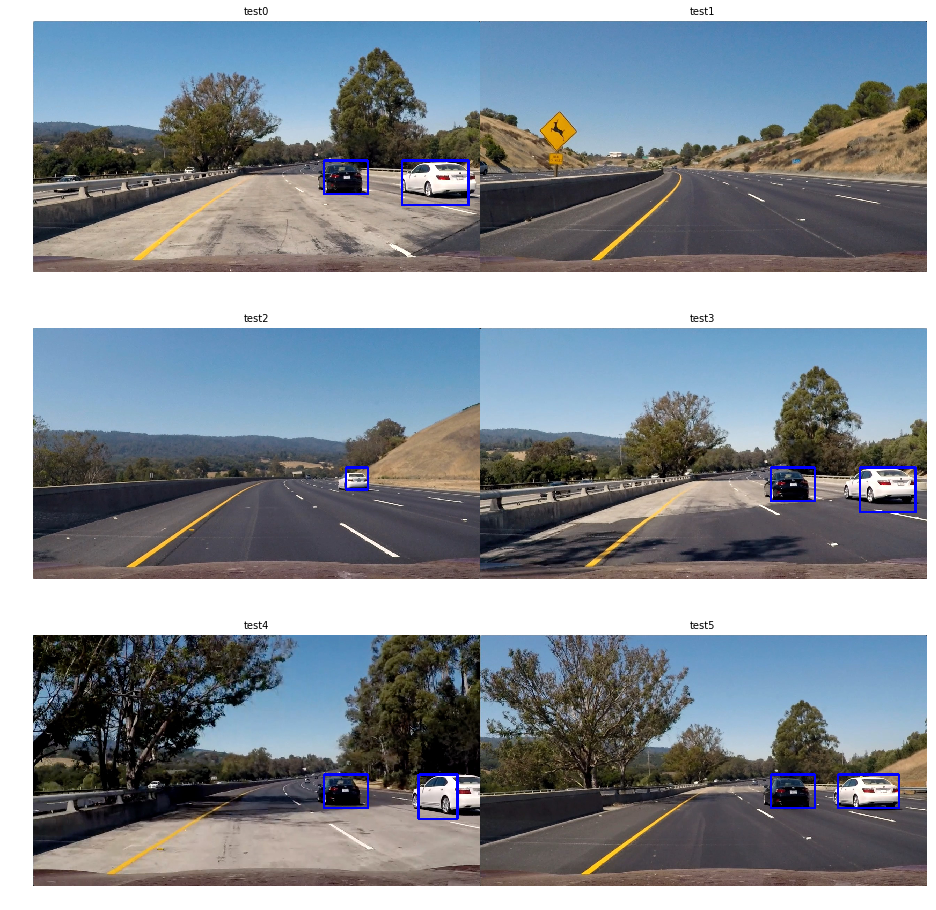

In [39]:
test_images = glob.glob('./test_images/test*.jpg')

detected_images = []
titles = []

for idx, path in enumerate(test_images):
    image = mpimg.imread(path)
    detected_image = process_image(image)
    detected_images.append(detected_image)
    
    titles.append("test"+str(idx))
    
    
show_table(detected_images, titles, 2, 3)

The pipeline does great on the test images! It was able to detect all of the cars and did not show any false detections. 

Before we jump to processing the videos, we need a one additional measure to ensure that our pipeline detects cars in every frame of the image. We also need a way to combine heatmaps from different frames to perform better elimination of false positives. 

Let's make a storage of latest detections from last N frames.

In [40]:
class DetectionStorage():
    
    def __init__(self, keep_frames):
        self.detected_boxes = [] 
        self.keep_frames = keep_frames
        
    def add_detections(self, boxes):
        self.detected_boxes.append(boxes)
        
        if len(self.detected_boxes) > self.keep_frames:
            self.detected_boxes = self.detected_boxes[len(self.detected_boxes)-self.keep_frames:]

And combine our storage with the pipeline.

In [41]:
storage = DetectionStorage(15)

def process_frame(image):

    rectangles = []
    
    scale = 1.0
    y_start = 400
    window_steps = 2
    rectangles.append(search_in_region(image, y_start, scale, window_steps))

    scale = 1.5
    y_start = 400
    window_steps = 2
    rectangles.append(search_in_region(image, y_start, scale, window_steps))

    scale = 1.5
    y_start = 432
    window_steps = 2
    rectangles.append(search_in_region(image, y_start, scale, window_steps))

    scale = 2.0
    y_start = 400
    window_steps = 2
    rectangles.append(search_in_region(image, y_start, scale, window_steps))

    scale = 2.0
    y_start = 464
    window_steps = 2
    rectangles.append(search_in_region(image, y_start, scale, window_steps))

    scale = 3.0
    y_start = 400
    window_steps = 1
    rectangles.append(search_in_region(image, y_start, scale, window_steps))

    scale = 3.0
    y_start = 464
    window_steps = 1
    rectangles.append(search_in_region(image, y_start, scale, window_steps))

    rectangles = [item for sublist in rectangles for item in sublist] 
    
    if len(rectangles) > 0:
        storage.add_detections(rectangles)
    
    heatmap_image = np.zeros_like(image[:,:,0])
    
    for detected_boxes_in_frame in storage.detected_boxes:
        heatmap_image = add_heat(heatmap_image, detected_boxes_in_frame)
        
    heatmap_image = apply_threshold(heatmap_image, 1 + len(storage.detected_boxes)//2)
    
    labels = label(heatmap_image)
 
    detected_overlay_image, rect = draw_labeled_bboxes(np.copy(image), labels)
    
    return detected_overlay_image

## Process a video

It's time to see how well the pipeline does on the project video.

In [42]:
out_path = "project_video_out_final.mp4"

clip_test2 = VideoFileClip("project_video.mp4")
clip_test_out2 = clip_test2.fl_image(process_frame)
%time clip_test_out2.write_videofile(out_path, audio=False)

[MoviePy] >>>> Building video project_video_out_final.mp4
[MoviePy] Writing video project_video_out_final.mp4


100%|█████████████████████████████████████▉| 1260/1261 [08:45<00:00,  2.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out_final.mp4 

Wall time: 8min 46s


In [43]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(out_path))

## My conclusion

The implemented pipeline does reasonably well on the project video. It looses the white car at some point for a second, but overall it detects cars in the video most of the time. It shows one false positive detection at the left side near the end of the video, but not for long. 

To further improve the performance of the pipeline I could use more filters and more clever way to identify heat threshold than just dividing number of frames by two. I could experiment with deep learning instead of SVM classifier or I even could use YOLO "you only look once" architecture of neural network to make a robust classifier.

The pipeline is likely to fail on cars which are different from the ones in the dataset and the dataset is quite small for a robust learning, so getting a bigger dataset will result in better and more robust predictions.

It's also possible that pipeline will produce many false positives on roads with more distinct detectable items except from cars and the road itself, such as traffic signs.